In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

from custom_libs import db
from custom_libs import preprocessing
from custom_libs import classification
from custom_libs import dump
from custom_libs import plotting

In [2]:
def transform_label_function(label):
    label = str(label)
    if label == "0":
        return classification.Sentiment.NEGATIVE
    elif label == "1":
        return classification.Sentiment.NEUTRAL
    elif label == "2":
        return classification.Sentiment.POSITIVE
    else:
       raise Exception(f"Invalid label: {label}")

In [3]:
x_column_name = "text"
x_column_cleaned_name = x_column_name + "_clean"
sentiment_column_name = "sentiment"

In [4]:
df = db.get_dataset("generic_sentiment_dataset")
df[sentiment_column_name] = df['label'].apply(transform_label_function)
df.head(5)

,sentiment,text,label
0,Positive,good mobile. battery is 5000 mah is very big. ...,2
1,Positive,Overall in hand ecpirience is quite good matt ...,2
2,Positive,"1. Superb Camera,\n2. No lag\n3. This is my fi...",2
3,Positive,Bigger size of application names doesn't allow...,2
4,Negative,Just a hype of stock android which is not flaw...,0


In [5]:
df = preprocessing.preprocess_df(df, x_column_name, x_column_cleaned_name)
df.head(10)

,sentiment,text,label,text_clean
0,Positive,good mobile. battery is 5000 mah is very big. ...,2,good mobile battery mah big camera quality good
1,Positive,Overall in hand ecpirience is quite good matt ...,2,overall hand ecpirience quite good matt finish...
2,Positive,"1. Superb Camera,\n2. No lag\n3. This is my fi...",2,superb camera lag first samsung phone earlier ...
3,Positive,Bigger size of application names doesn't allow...,2,big size application name allow name view full
4,Negative,Just a hype of stock android which is not flaw...,0,hype stock android flawless well custom ui lau...
5,Negative,First day mobile go to the conditions bad,0,first day mobile go condition bad
6,Neutral,Only for formal use its ok. If you want best c...,1,formal use ok want best camera sound quality i...
7,Negative,Battery Problem After 05 Month,0,battery problem month
8,Negative,"Confusing OS,Very low sound , worst camera qua...",0,confuse o low sound bad camera quality perform...
9,Neutral,Why its locked to indian Network only???\nI ca...,1,lock indian network use abroad useless trick s...


In [6]:
X, y = df[x_column_cleaned_name], df[sentiment_column_name]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy for PassiveAggressiveClassifier with vectorizer CountVectorizer: 0.7349444444444444
Accuracy for PassiveAggressiveClassifier with vectorizer TfidfVectorizer - Unigram: 0.7737222222222222
Accuracy for PassiveAggressiveClassifier with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigram: 0.7737777777777778
Accuracy for PassiveAggressiveClassifier with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigram, Bigram: 0.8377777777777777
Accuracy for PassiveAggressiveClassifier with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigram, Bigram, Trigram: 0.8456666666666667


Accuracy for LogisticRegression with vectorizer CountVectorizer: 0.7709444444444444
Accuracy for LogisticRegression with vectorizer TfidfVectorizer - Unigram: 0.7581666666666667
Accuracy for LogisticRegression with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigram: 0.7581666666666667
Accuracy for LogisticRegression with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigram, Bigram: 0.8022222222222222
Accuracy for L

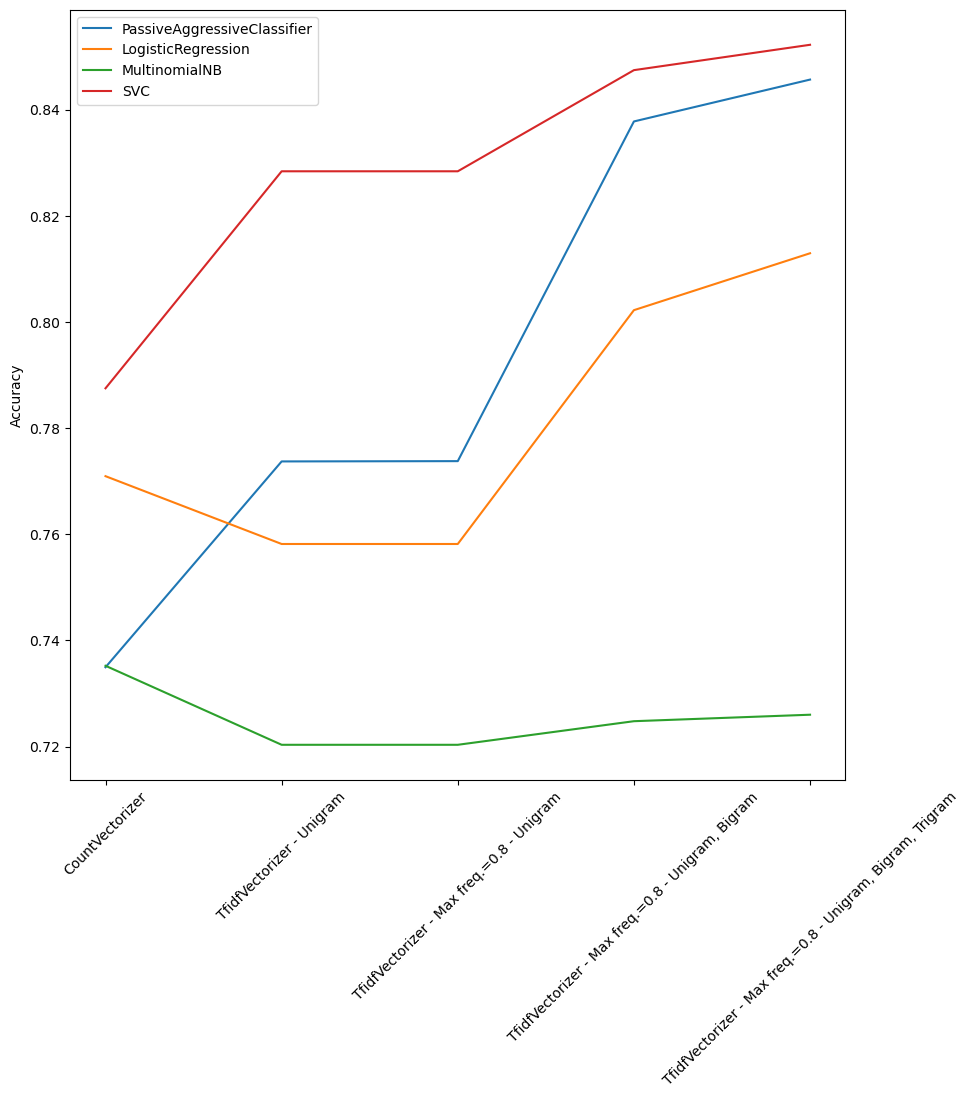

In [7]:
vectorizers = list()
vectorizers.append(CountVectorizer(stop_words='english'))
vectorizers.append(TfidfVectorizer(stop_words='english'))
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8))
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2)))
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3)))

labels_vectorizers = [
    'CountVectorizer', 
    'TfidfVectorizer - Unigram', 
    'TfidfVectorizer - Max freq.=0.8 - Unigram', 
    'TfidfVectorizer - Max freq.=0.8 - Unigram, Bigram', 
    'TfidfVectorizer - Max freq.=0.8 - Unigram, Bigram, Trigram',
    ]

models = [PassiveAggressiveClassifier, LogisticRegression, MultinomialNB, SVC]

results_accuracies = classification.test_classifiers(models, vectorizers, labels_vectorizers, x_train, x_test, y_train, y_test)

plotting.plot_accuracies(results_accuracies, labels_vectorizers)

Accuracy: 0.8522222222222222
Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.87      0.85      5048
     Neutral       0.84      0.57      0.68      3517
    Positive       0.87      0.95      0.90      9435

    accuracy                           0.85     18000
   macro avg       0.85      0.80      0.81     18000
weighted avg       0.85      0.85      0.85     18000

Confusion matrix, without normalization


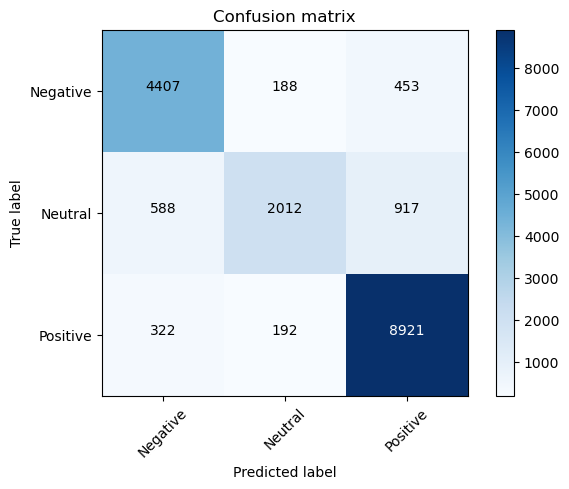

In [8]:
# Best combination of model and vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
x_train_trasformed = vectorizer.fit_transform(x_train)
x_test_trasformed = vectorizer.transform(x_test)

class_names = classification.Sentiment.get_all()
model = SVC()
model.fit(x_train_trasformed, y_train)
y_pred = model.predict(x_test_trasformed)
classification.show_results(y_test, y_pred, class_names)

In [9]:
dump.save_model(model, "our_model")
dump.save_vectorizer(vectorizer, "our_vectorizer")

Saving model at: dump_models/our_model.pkl
Saving vectorizer at: dump_models/our_vectorizer.pkl
